<a href="https://colab.research.google.com/github/fitriasyira/CUTe_DLWORKSHOP/blob/main/ASSIGNMENT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
#import the file from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=64), #dataAugmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=64),
        transforms.CenterCrop(size=64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/gdrive/MyDrive/kneeXray'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}
# directory path 
# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
5
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [ ]:
# # constant for classes
classes = ('0', '1', '2', '3', '4')

In [ ]:
data['train']

Dataset ImageFolder
    Number of datapoints: 5778
    Root location: /content/gdrive/MyDrive/kneeXray/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [ ]:
print(train_data_size)
print(test_data_size)

5778
826


In [ ]:
# DEFINE YOUR OWN MODEL (pretrained model :convnext_tiny)

model_ft = models.convnext_tiny(pretrained=True)
num_ftrs = model_ft.classifier[2].in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[2] = nn.Linear(num_ftrs, 5)

#######################

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [ ]:
#To check the details of the model
from torchsummary import summary
print(summary(model_ft,(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.4227, Accuracy: 37.6428%, 
		Validation : Loss : 1.4021, Accuracy: 38.4988%, Time: 1148.9463s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.3972, Accuracy: 38.8197%, 
		Validation : Loss : 1.3587, Accuracy: 38.6199%, Time: 28.6347s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.3611, Accuracy: 40.0485%, 
		Validation : Loss : 1.3113, Accuracy: 40.1937%, Time: 28.6028s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.2903, Accuracy: 43.0253%, 
		Validation : Loss : 1.2254, Accuracy: 47.6998%, Time: 29.2293s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.2169, Accuracy: 46.8501%, 
		Validation : Loss : 1.1684, Accuracy: 46.4891%, Time: 28.4897s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.1503, Accuracy: 49.5500%, 
		Validation : Loss : 1.0791, Accuracy: 54.1162%, Time: 28.6531s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.1296, Accuracy: 50.6750%, 
		Validation : Loss : 1.0887, Accuracy: 50.9685%, Time: 30.6237s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.0878, Accu

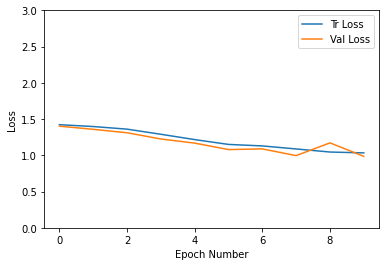

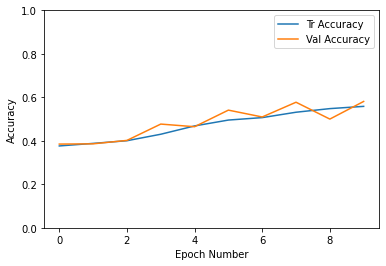

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

Question 2 : The training of the model using custom CNN of three hidden layers on the dataset after modification with batchnorm and dropout to improve the performance of the model

In [ ]:
#DEFINE CNN
#A conv layer with 3 channels as input, 10 channels as output, and a 5x5 kernel
#A 2x2 max-pooling layer
#A conv layer with 10 channels as input, 15 channels as output, and a 3x3 kernel
#A 2x2 max-pooling layer
#Apply batchnorm 
#A conv layer with 15 channels as input, 20 channels as output, and a 3x3 kernel
#A 2x2 max-pooling layer
#A linear layer with 6x6x20 nodes
#A linear layer with 100 nodes
#A linear layer with 5 nodes
#Applying Dropout
 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        #(input=D, output=K, channel=F)
        self.pool1 = nn.MaxPool2d(2, 2)
        #nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.batchnorm = nn.BatchNorm2d(10) #(equal to number of output channel on conv)
        self.conv2 = nn.Conv2d(10, 15, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(15, 20, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6*6*20, 100)
        self.dropout = nn.Dropout(p = 0.2)#probability
        self.fc2 = nn.Linear(100, 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.batchnorm(x) # sebab channel 10
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = x.view(-1, 6 * 6 * 20)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=720, out_features=100, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
  (relu): ReLU()
)

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.4621, Accuracy: 36.7947%, 
		Validation : Loss : 1.4073, Accuracy: 39.7094%, Time: 20.2616s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.4042, Accuracy: 39.5466%, 
		Validation : Loss : 1.4007, Accuracy: 39.7094%, Time: 19.9167s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.3993, Accuracy: 39.5466%, 
		Validation : Loss : 1.3965, Accuracy: 39.7094%, Time: 20.8849s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.3939, Accuracy: 39.6331%, 
		Validation : Loss : 1.3927, Accuracy: 39.7094%, Time: 20.5200s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.3915, Accuracy: 39.5812%, 
		Validation : Loss : 1.3879, Accuracy: 39.7094%, Time: 20.0866s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.3892, Accuracy: 39.6677%, 
		Validation : Loss : 1.3842, Accuracy: 39.7094%, Time: 20.0443s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.3837, Accuracy: 39.5985%, 
		Validation : Loss : 1.3771, Accuracy: 39.9516%, Time: 20.4987s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.3767, Accura

Question 3 : The training of the model using transfer learning on the dataset

In [ ]:
#######################
# DEFINE YOUR OWN MODEL

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

#######################

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.4701, Accuracy: 36.6563%, 
		Validation : Loss : 1.4520, Accuracy: 40.5569%, Time: 25.0272s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.2960, Accuracy: 44.4618%, 
		Validation : Loss : 1.2608, Accuracy: 47.3366%, Time: 23.9693s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.2226, Accuracy: 47.5770%, 
		Validation : Loss : 1.2741, Accuracy: 41.2833%, Time: 23.6946s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.1877, Accuracy: 49.0135%, 
		Validation : Loss : 1.1663, Accuracy: 51.5738%, Time: 24.0850s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.1497, Accuracy: 50.3461%, 
		Validation : Loss : 1.1095, Accuracy: 53.1477%, Time: 24.8648s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.1325, Accuracy: 50.8654%, 
		Validation : Loss : 1.1374, Accuracy: 53.9952%, Time: 25.3974s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.1194, Accuracy: 51.5749%, 
		Validation : Loss : 1.2237, Accuracy: 50.3632%, Time: 24.5656s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.0810, Accura

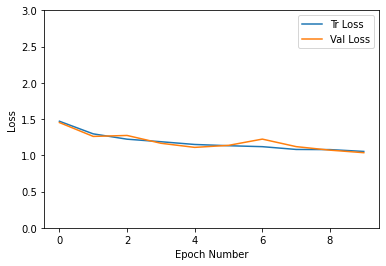

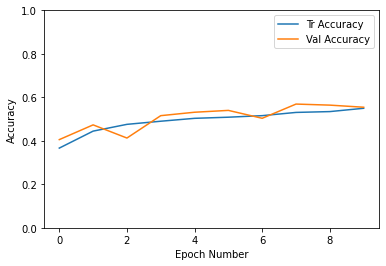

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [ ]:
#To check the details of the model
from torchsummary import summary
print(summary(model_ft,(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

QUESTION : Perform inference on 3 different sample

In [ ]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

torch.Size([1, 5])
Minimal 0.32549193501472473
Moderate 0.27863189578056335
Doubtful 0.17091451585292816
Healthy 0.16121159493923187
Severe 0.06375016272068024


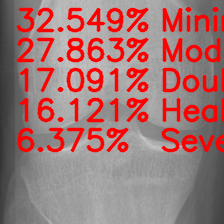

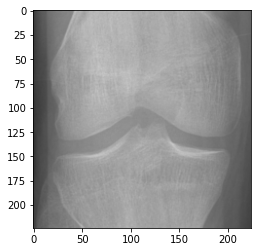

In [ ]:
#SAMPLE1
from requests import get

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

file_name = "/content/gdrive/MyDrive/Assignment Test/0_9243046_1.png"

import cv2
img1 = cv2.imread(file_name)
rgb_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img1)

from torchvision import transforms

transform = transforms.Compose([transforms.ToPILImage(),         #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

img_t = transform(img1)
batch_t = torch.unsqueeze(img_t, 0)

out = model_ft(batch_t)
print(out.shape)

from google.colab.patches import cv2_imshow

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    cv2.putText(img1, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img1, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

torch.Size([1, 5])
Moderate 0.2804788053035736
Minimal 0.24432332813739777
Doubtful 0.1623922735452652
Healthy 0.1569247990846634
Severe 0.1558808535337448


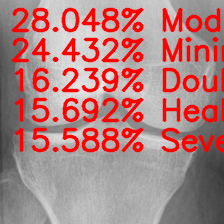

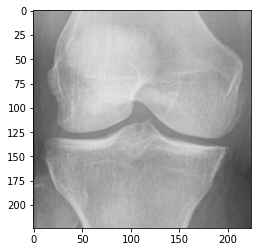

In [ ]:
#sample 2
from requests import get

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

sample2 = "/content/gdrive/MyDrive/Assignment Test/2_9487842_1.png"

import cv2
img2 = cv2.imread(sample2)
rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img2)

model_ft.eval()

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
        ])

img_t2 = transform(img2)
batch_t = torch.unsqueeze(img_t2, 0).to(device)

out = model_ft(batch_t)
print(out.shape)

from google.colab.patches import cv2_imshow
#constant for classes
classes = ('Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe')
# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities,5)

for i in range(top5_prob.size(0)):
    cv2.putText(img2, f"{top5_prob[i].item()*100:.3f}%", (10, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img2, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

torch.Size([1, 5])
Moderate 0.25687524676322937
Minimal 0.21830205619335175
Severe 0.18274053931236267
Helathy 0.17547787725925446
Doubtful 0.16660429537296295


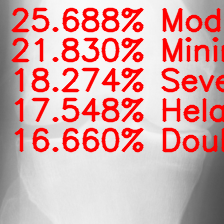

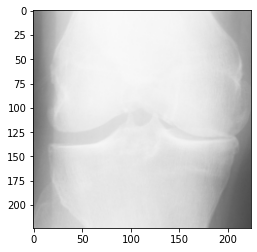

In [ ]:
#sample3
from requests import get

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

sample3 = "/content/gdrive/MyDrive/Assignment Test/4_9390064_1.png"

import cv2
img3 = cv2.imread(sample3)
rgb_img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img3)

model_ft.eval()

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
        ])

img_t3 = transform(img3)
batch_t = torch.unsqueeze(img_t3, 0).to(device)

out = model_ft(batch_t)
print(out.shape)

from google.colab.patches import cv2_imshow
#constant for classes
classes = ('Helathy', 'Doubtful', 'Minimal', 'Moderate', 'Severe')
# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities,5)

for i in range(top5_prob.size(0)):
    cv2.putText(img3, f"{top5_prob[i].item()*100:.3f}%", (10, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img3, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img3)
cv2.waitKey(0)
cv2.destroyAllWindows()